A collection of deep learning models in JAX.

*   Author: Tianlin Liu
*   GitHub Repository: https://github.com/liutianlin0121/jax-deep-learning-models

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/liutianlin0121/jax-deep-learning-models/blob/main/AE/vae-conv-mnist.ipynb)


## Description

In this notebook, we will be training a ConvNet-based [variational autoencoder](https://arxiv.org/abs/1312.6114) on the MNIST dataset.

## Imports

In [1]:
if 'google.colab' in str(get_ipython()):
  %pip install ml-collections -q
  %pip install "jax[cuda11_cudnn82]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html -q
  %pip install flax -q

In [2]:
from matplotlib import pyplot as plt
import numpy as np
import jax
import jax.numpy as jnp
from flax import linen as nn
from flax.training import train_state
import ml_collections
import optax

import torchvision
from torch.utils import data

## Prepare the MNIST dataset

Text(0.5, 0.9, 'Binarized MNIST samples')

<Figure size 640x480 with 0 Axes>

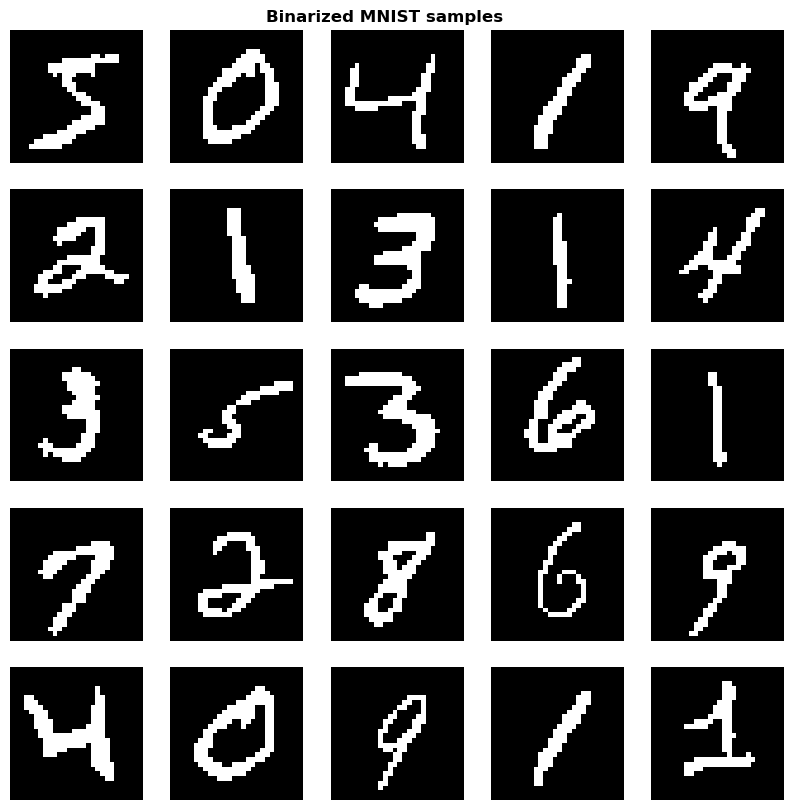

In [3]:
# Helper functions for images.
def show_img(img, ax=None, title=None, cmap='gray'):
  """Shows a single image."""
  if ax is None:
    ax = plt.gca()
  ax.imshow(img.squeeze(), cmap=cmap)
  ax.set_xticks([])
  ax.set_yticks([])
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  ax.spines['bottom'].set_visible(False)
  ax.spines['left'].set_visible(False)
  if title:
    ax.set_title(title)


def show_img_grid(imgs, titles, cmap='gray'):
  """Shows a grid of images."""
  n = int(np.ceil(len(imgs)**.5))
  _, axs = plt.subplots(n, n, figsize=(2 * n, 2 * n))
  for i, (img, title) in enumerate(zip(imgs, titles)):
    show_img(img, axs[i // n][i % n], title, cmap)


def numpy_collate(batch):
  """Stack data into a numpy array.
  https://jax.readthedocs.io/en/latest/notebooks/Neural_Network_and_Data_Loading.html
  """
  if isinstance(batch[0], np.ndarray):
    return np.stack(batch)
  elif isinstance(batch[0], (tuple, list)):
    transposed = zip(*batch)
    return [numpy_collate(samples) for samples in transposed]
  else:
    return np.array(batch)


def binarize(x):
  """Binarizes a numpy array."""
  return (x > 0.5).astype(np.float32)

class CastAndNormalize(object):
  """Cast and normalize an image.
  https://jax.readthedocs.io/en/latest/notebooks/Neural_Network_and_Data_Loading.html
  """
  def __call__(self, pic):
    # we consider binarized MNIST in this VAE example
    return binarize(np.array(pic, dtype=jnp.float32)[..., np.newaxis] / 255)

train_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets",
    train=True,
    transform=CastAndNormalize(),
    download=True
)

test_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets",
    train=False,
    transform=CastAndNormalize(),
    download=True
)

plt.figure()
show_img_grid(
  [train_dataset[idx][0].reshape((28, 28)) for idx in range(25)],
  [None for idx in range(25)],
)
plt.suptitle('Binarized MNIST samples', y=0.9, fontweight='bold')



## Set up the model and the training loop

The training loop setup here closely follows the the examples provided in the [flax repository](https://github.com/google/flax/tree/main/examples), sometimes verbatim.


In [4]:
class Encoder(nn.Module):
  """A VAE encoder with dense layers"""
  @nn.compact
  def __call__(self, x):
    x = nn.Conv(features=2, kernel_size=(3, 3))(x)
    x = nn.relu(x)
    # [B, 28, 28, 2]

    x = nn.max_pool(x, window_shape=(2,2), strides=(2,2))
    # [B, 14, 14, 2]

    x = nn.Conv(features=4, kernel_size=(3, 3))(x)
    x = nn.relu(x)
    # [B, 14, 14, 4]

    x = nn.max_pool(x, window_shape=(2,2), strides=(2,2))
    # [B, 7, 7, 4]

    x = x.reshape(x.shape[0], -1)
    x = nn.relu(x)
    # [B, 7* 7* 4]

    x = nn.Dense(features=100)(x)
    x = nn.relu(x)

    # the mean of the latent variable
    mean = nn.Dense(features=50)(x)
    # the log variance of the latent variable
    logvar = nn.Dense(features=50)(x)
    return mean, logvar


class Decoder(nn.Module):
  """A VAE decoder with dense layers."""
  @nn.compact
  def __call__(self, x):
    x = nn.Dense(features=7*7*2)(x)
    x = nn.relu(x)
    # [B, 7* 7* 2]

    x = x.reshape(x.shape[0], 7, 7, 2)
    # [B, 7, 7, 2]

    x = nn.Conv(features=64, kernel_size=(3, 3))(x)
    x = nn.relu(x)
    # [B, 7, 7, 64]

    x = nn.ConvTranspose(
      features=8, kernel_size=(3, 3), strides=(2,2))(x)
    x = nn.relu(x)
    # [B, 14, 14, 8]
    x = nn.Conv(features=8, kernel_size=(3, 3))(x)
    x = nn.relu(x)

    x = nn.ConvTranspose(
      features=4, kernel_size=(3, 3), strides=(2,2))(x)
    x = nn.relu(x)
    # [B, N, N, 4]
    x = nn.Conv(features=4, kernel_size=(3, 3))(x)
    x = nn.relu(x)

    logits = nn.Conv(features=1, kernel_size=(1, 1))(x)
    # [B, N, N, 1]
    return logits

def reparametrization(rng, mean, logvar):
  """Reparametrization trick for sampling from a Gaussian distribution.
  """
  # note that log(var) = log(std ** 2) = 2 * log(std),
  # so std = exp(0.5 * logvar)
  std = jnp.exp(0.5 * logvar)
  eps = jax.random.normal(rng, std.shape)
  return mean + eps * std

@jax.vmap
def kl_divergence(mean, logvar):
  """KL divergence between a Gaussian and a standard Gaussian.
  See https://stats.stackexchange.com/questions/7440/kl-divergence-between-two-univariate-gaussians
  """
  return -0.5 * jnp.sum(1 + logvar - mean ** 2 - jnp.exp(logvar))

@jax.vmap
def binary_cross_entropy_with_logits(logits, labels):
  logits = nn.log_sigmoid(logits)
  return -jnp.sum(labels * logits + (1. - labels) * jnp.log(-jnp.expm1(logits)))

class ConvVAE(nn.Module):
  """A convolutional variational autoencoder."""

  def setup(self):
    self.encoder = Encoder()
    self.decoder = Decoder()

  def __call__(self, x, rng):
    # get the mean and logvar of the posterior distribution
    mean, logvar = self.encoder(x)

    # sample a latent from the posterior distribution
    latent = reparametrization(rng, mean, logvar)
    recon = self.decoder(latent)
    return recon, latent, mean, logvar

  def generate(self, latent):
    return self.decoder(latent)


In [5]:
@jax.jit
def train_step(state, images, targets, rng):
  """Train on one batch of data."""
  def loss_fn(params):
    recon, z, mean, logvar = state.apply_fn({'params': params}, images, rng)
    loss_kl = kl_divergence(mean, logvar).mean()
    loss_ce = binary_cross_entropy_with_logits(recon, targets).mean()
    loss_total = loss_kl + loss_ce
    return loss_total, (loss_kl, loss_ce, recon)

  grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
  (loss_total, (loss_kl, loss_ce, recon)), grads = grad_fn(state.params)

  state = state.apply_gradients(grads=grads)
  return state, loss_total, loss_kl, loss_ce



def train_epoch(state, train_loader, epoch_rng):
  """Train for a single epoch."""

  epoch_losses = {}
  epoch_loss_total = []
  epoch_loss_kl = []
  epoch_loss_ce = []

  for batch_images, _ in train_loader:
    epoch_rng, batch_rng = jax.random.split(epoch_rng)
    state, loss_total, loss_kl, loss_ce = train_step(
      state, batch_images, batch_images, batch_rng)
    epoch_loss_total.append(loss_total)
    epoch_loss_kl.append(loss_kl)
    epoch_loss_ce.append(loss_ce)

  epoch_losses['total'] = np.mean(epoch_loss_total)
  epoch_losses['kl'] = np.mean(epoch_loss_kl)
  epoch_losses['ce'] = np.mean(epoch_loss_ce)
  return state, epoch_losses


def create_train_state(rng, config):
  """Creates initial `TrainState`."""
  param_rng, z_rng = jax.random.split(rng)

  mlp = ConvVAE()
  params = mlp.init(param_rng, jnp.ones([1, 28, 28, 1]), z_rng)['params']
  tx = optax.adam(config.learning_rate)
  return train_state.TrainState.create(
    apply_fn=mlp.apply, params=params, tx=tx)


def train_and_evaluate(
  config: ml_collections.ConfigDict) -> train_state.TrainState:
  """Execute model training and evaluation loop.

  Args:
    config: Hyperparameter configuration for training and evaluation.

  Returns:
    The train state (which includes the `.params`).
  """
  train_loader = data.DataLoader(
    train_dataset, batch_size=config.batch_size,
    shuffle=True, num_workers=4, pin_memory=True,
    collate_fn=numpy_collate, drop_last=True)

  rng = jax.random.PRNGKey(42)

  rng, init_rng = jax.random.split(rng)
  state = create_train_state(init_rng, config)

  for epoch in range(1, config.num_epochs + 1):
    rng, epoch_rng = jax.random.split(rng)
    state, train_losses = train_epoch(state, train_loader, epoch_rng)

    total_loss = train_losses['total']
    kl_loss = train_losses['kl']
    ce_loss = train_losses['ce']
    print(f'epoch: {epoch:02d}/{config.num_epochs:02d} | ' +\
      f'train_loss_total: {total_loss:.4f} | ' +\
      f'train_loss_kl: {kl_loss:.4f} | ' +\
      f'train_loss_ce: {ce_loss:.4f} | '
      )

  return state

## Training

In [6]:
config = ml_collections.ConfigDict()

config.learning_rate = 1e-3
config.batch_size = 128
config.num_epochs = 50

state = train_and_evaluate(config)

epoch: 01/50 | train_loss_total: 212.6348 | train_loss_kl: 16.8407 | train_loss_ce: 195.7941 | 
epoch: 02/50 | train_loss_total: 139.0522 | train_loss_kl: 28.9319 | train_loss_ce: 110.1203 | 
epoch: 03/50 | train_loss_total: 122.5861 | train_loss_kl: 30.7141 | train_loss_ce: 91.8720 | 
epoch: 04/50 | train_loss_total: 113.1230 | train_loss_kl: 30.8209 | train_loss_ce: 82.3021 | 
epoch: 05/50 | train_loss_total: 107.1062 | train_loss_kl: 30.7708 | train_loss_ce: 76.3354 | 
epoch: 06/50 | train_loss_total: 103.3048 | train_loss_kl: 30.8221 | train_loss_ce: 72.4826 | 
epoch: 07/50 | train_loss_total: 100.9309 | train_loss_kl: 30.9866 | train_loss_ce: 69.9443 | 
epoch: 08/50 | train_loss_total: 99.0735 | train_loss_kl: 31.1264 | train_loss_ce: 67.9471 | 
epoch: 09/50 | train_loss_total: 97.9361 | train_loss_kl: 31.2958 | train_loss_ce: 66.6403 | 
epoch: 10/50 | train_loss_total: 96.9807 | train_loss_kl: 31.3871 | train_loss_ce: 65.5936 | 
epoch: 11/50 | train_loss_total: 96.1068 | train_lo

## Inference

In [7]:
test_images = jnp.array([test_data[0] for test_data in test_dataset])
test_labels = jnp.array([test_data[1] for test_data in test_dataset])

z_rng = jax.random.PRNGKey(42)
test_recons, test_latents, test_mean, test_logvar = ConvVAE(
  ).apply({'params': state.params}, test_images, z_rng)
test_recons = nn.sigmoid(test_recons)

Text(0.5, 0.99, 'Orig image (top) and reconstruction (bottom)')

<Figure size 640x480 with 0 Axes>

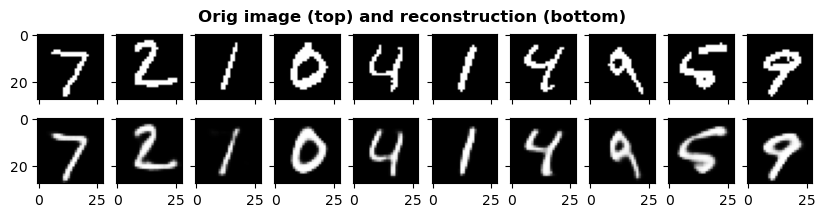

In [8]:
n_images = 10
image_width = 28

plt.figure()

fig, axes = plt.subplots(
  nrows=2,
  ncols=n_images,
  sharex=True,
  sharey=True,
  figsize=(n_images, 2))

orig_images = test_images[:n_images]
decoded_images = test_recons[:n_images]

for i in range(n_images):
  for ax, img in zip(axes, [orig_images, decoded_images]):
    curr_img = img[i]
    ax[i].imshow(curr_img.reshape((image_width, image_width)), cmap='gray')

plt.suptitle("Orig image (top) and reconstruction (bottom)",
             y=0.99, fontsize=12, fontweight="bold")

## Generate new images

In [9]:
rng = jax.random.PRNGKey(42)

n_images = 25
rng, rand_sample_rng = jax.random.split(rng)

rand_latents = jax.random.normal(rng, (n_images, 50))

new_images = ConvVAE().apply(
    {'params': state.params}, method=ConvVAE.generate, latent=rand_latents)
new_images = nn.sigmoid(new_images)

Text(0.5, 0.9, 'Randomly generated samples')

<Figure size 640x480 with 0 Axes>

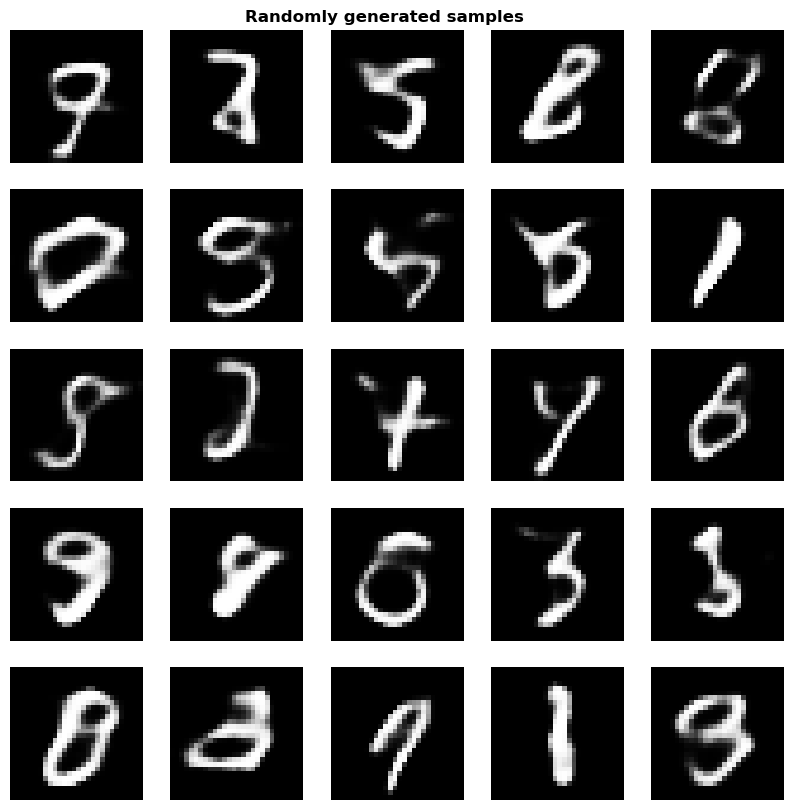

In [10]:
plt.figure()

show_img_grid(
  [a.reshape(image_width, image_width) for a in new_images],
  [None for idx in range(25)], cmap='gray')

plt.suptitle('Randomly generated samples', y=0.9, fontweight='bold')
